In [131]:
import numpy as np

# dummy tensor field
# make tensor pointing vertically
up = np.array([[8,0,0],
              [0,1,0],
              [0,0,1]])

# make tensor pointing horizontally
right = np.array([[1,0,0],
              [0,8,0],
              [0,0,1]])

# identity
id = np.array([[1,0,0],
               [0,1,0],
               [0,0,1]])

# initialize tensor field
T = np.zeros((6,7,2,3,3))

T[1:3, 1:6, ...] = up
T[3:5, 1:6, ...] = right
T[:1,...] = id # pad the edges with the identity matrix
T[5:,...] = id
T[:,:1,...] = id
T[:,6:,...] = id


<IPython.core.display.Javascript object>


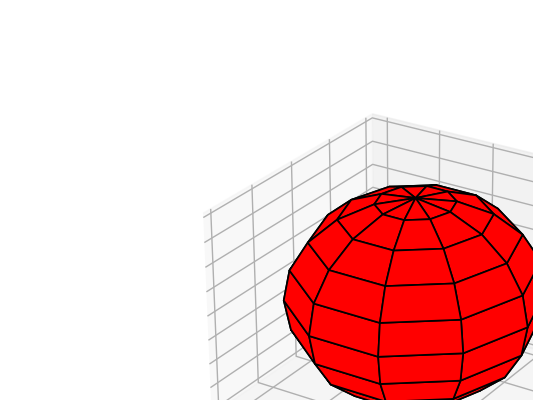

In [132]:
# now we have to draw ellipses
# first draw a square
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.linalg import sqrtm
f = plt.figure()
ax = f.add_subplot(projection='3d')

n0 = 10
n1 = 10
t0 = np.arange(n0+1)/n0 * 2.0*np.pi # alpha
t1 = np.arange(n1+1)/n1 * np.pi # polar
T0,T1 = np.meshgrid(t0,t1,indexing='ij')
Y0 = np.sin(T1)*np.cos(T0)
Y1 = np.sin(T1)*np.sin(T0)
Y2 = np.cos(T1)
ax.plot_surface(Y0,Y1,Y2,shade=False,color='r',edgecolor='k')

w,v = np.linalg.eigh(T)
trace = np.sum(w,-1)

R = T/np.trace(T,axis1=-1,axis2=-2)[...,None,None]
FA = np.sqrt(0.5*(3.0 - 1.0/np.trace(R@R,axis1=-1,axis2=-2)))
FA[np.isnan(FA)] = 0

In [287]:
# create grid
xI = []
for i in range(3):
    x = np.arange(T.shape[i]) - (T.shape[i]-1)/2
    xI.append(x)
X = np.stack(np.meshgrid(xI[0],xI[1],xI[2], indexing='ij'),axis=-1)

# make rotation matrices
theta = -np.pi / 4
Rz = np.array([[np.cos(theta), -np.sin(theta), 0],
              [np.sin(theta), np.cos(theta), 0],
              [0,0,1]])
Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
              [0, 1, 0],
              [-np.sin(theta),0,np.cos(theta)]])
Rx = np.array([[1,0,0],
               [0, np.cos(theta), -np.sin(theta)],
               [0, np.sin(theta), np.cos(theta)]])

# rotate grid 45 degrees about z axis
dv = [1.,1.,1.]
Xrot = (Rz @ X[...,None])[...,0]#.transpose(3,0,1,2)

jacobian = lambda X,dv : np.stack(np.gradient(X, dv[0],dv[1],dv[2], axis=(0,1,2)), axis=-1)#.transpose(2,3,4,0,1)
J = jacobian(Xrot, dv)
Jinv = np.linalg.inv(J)
JinvT = Jinv.transpose(0,1,2,4,3)

<IPython.core.display.Javascript object>


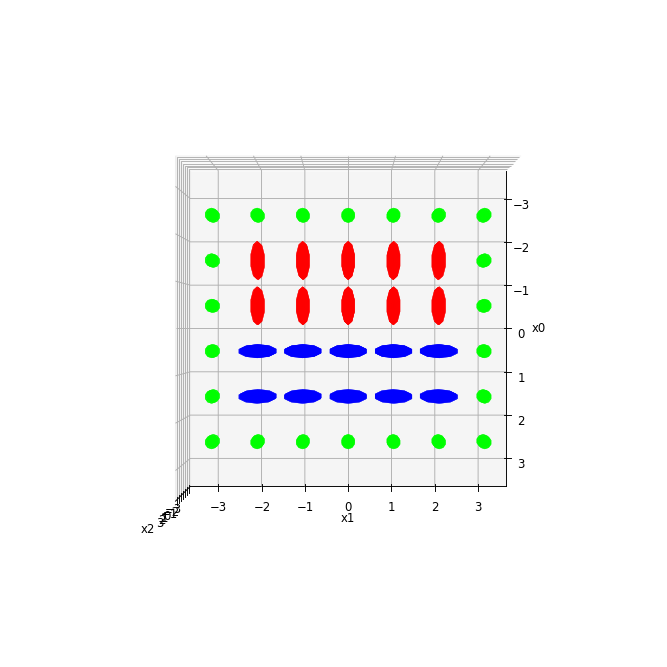

In [288]:
from matplotlib import cm

f = plt.figure(figsize=(8,8))
ax = f.add_subplot(projection='3d')
ax.view_init(elev=90,azim=0)

d = 1
for i in range(0,T.shape[0],d):
    for j in range(0,T.shape[1],d):
        for k in range(0,T.shape[2],d):
            A = T[i,j,k]
            A12 = sqrtm(A)
            Z0 = A12[0,0]*Y0 + A12[0,1]*Y1 + A12[0,2]*Y2
            Z1 = A12[1,0]*Y0 + A12[1,1]*Y1 + A12[1,2]*Y2
            Z2 = A12[2,0]*Y0 + A12[2,1]*Y1 + A12[2,2]*Y2
            scale = 0.15#*FA[i,j]        
            ax.plot_surface(scale*Z0+X[i,j,k,0],scale*Z1+X[i,j,k,1],scale*Z2+X[i,j,k,2],shade=False,color=np.abs(v[i,j,k,-2]),edgecolor=None)
            ax.set_xlim(-3.5,3.5)
            ax.set_ylim(-3.5,3.5)
            ax.set_zlim(-3.5,3.5)
            ax.set_xlabel('x0')
            ax.set_ylabel('x1')
            ax.set_zlabel('x2')

In [289]:
tensors = T
J = Jinv
# J = JinvT
# define function to construct rotation matrix from axis of rotation and angle
rot = lambda n, theta : np.array([[np.cos(theta)+n[...,0,None]**2*(1-np.cos(theta)), n[...,0,None]*n[...,1,None]*(1-np.cos(theta))-n[...,2,None]*np.sin(theta), n[...,0,None]*n[...,2,None]*(1-np.cos(theta))+n[...,1,None]*np.sin(theta)],
                                [n[...,0,None]*n[...,1,None]*(1-np.cos(theta))+n[...,2,None]*np.sin(theta), np.cos(theta)+n[...,1,None]**2*(1-np.cos(theta)), n[...,1,None]*n[...,2,None]*(1-np.cos(theta))-n[...,0,None]*np.sin(theta)],
                                [n[...,0,None]*n[...,2,None]*(1-np.cos(theta))-n[...,1,None]*np.sin(theta), n[...,1,None]*n[...,2,None]*(1-np.cos(theta))+n[...,0,None]*np.sin(theta), np.cos(theta)+n[...,2,None]**2*(1-np.cos(theta))]]).squeeze().transpose(2,3,4,0,1)

# compute unit eigenvectors, e, of tensors
w,e = np.linalg.eigh(tensors)
e1 = e[...,-1]
e2 = e[...,-2]
# compute unit vectors n1 and n2 in the directions of J@e1 and J@e2
Je1 = np.squeeze(J @ e1[...,None])
n1 = Je1 / np.linalg.norm(Je1, axis=-1)[...,None]
Je2 = np.squeeze(J @ e2[...,None])
n2 = Je2 / np.linalg.norm(Je2, axis=-1)[...,None]
# compute a rotation matrix, R1, that maps e1 onto n1
theta = np.arccos(np.squeeze(e1[..., None, :] @ n1[..., None]))[...,None]
r = np.cross(e1,n1) / np.sin(theta)
nrand = np.random.rand(3)
nrand = nrand / np.linalg.norm(nrand)
theta2 = np.arccos(np.squeeze(e1[..., None, :] @ n2[..., None]))[...,None]
r2 = np.cross(e1,n2) / np.sin(theta2)
r[np.isnan(r)] = r2[np.isnan(r)]
# theta[np.where(theta==0)] = theta2[np.where(theta==0)]
R1 = rot(r,theta)
# compute a secondary rotation, about n1, to map e2 from its position after the first rotation, R1 @ e2,
# to the n1-n2 plane.
Pn2 = n2 - (n2[..., None, :] @ n1[..., None])[...,0] * n1
Pn2 = Pn2 / np.linalg.norm(Pn2, axis=-1)[...,None]
R1e1 = np.squeeze(R1 @ e1[...,None])
R1e2 = np.squeeze(R1 @ e2[...,None])
phi = np.arccos(np.squeeze(R1e2[..., None, :] @ Pn2[..., None]) / (np.linalg.norm(R1e2) * np.linalg.norm(Pn2)))[...,None]
R2 = rot(R1e1, phi)

Q = R2 @ R1

/tmp/ipykernel_296194/2704172997.py:20: RuntimeWarning: invalid value encountered in true_divide
  r = np.cross(e1,n1) / np.sin(theta)


In [290]:
Trot = Q @ T @ Q.transpose(0,1,2,4,3)

<IPython.core.display.Javascript object>


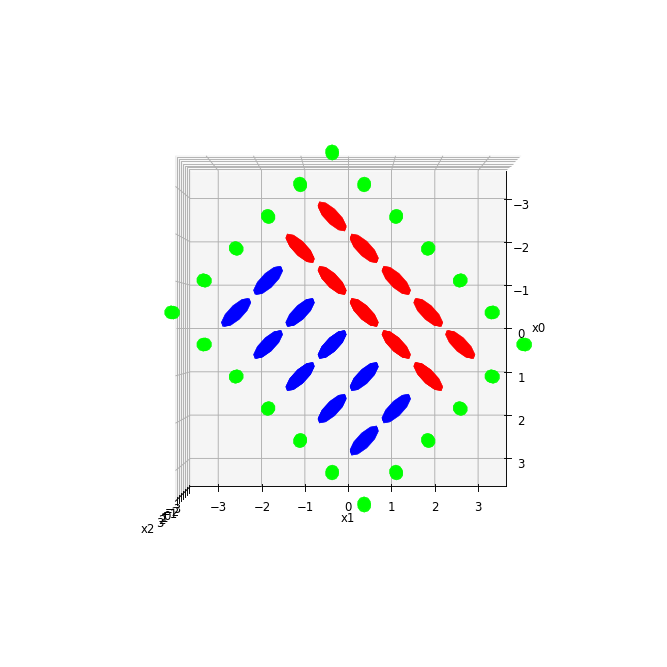

In [294]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(projection='3d')
ax.view_init(elev=90,azim=0)

d = 1
for i in range(0,Trot.shape[0],d):
    for j in range(0,Trot.shape[1],d):
        for k in range(0,Trot.shape[2],d):
            A = Trot[i,j,k]
            A12 = sqrtm(A)
            Z0 = A12[0,0]*Y0 + A12[0,1]*Y1 + A12[0,2]*Y2
            Z1 = A12[1,0]*Y0 + A12[1,1]*Y1 + A12[1,2]*Y2
            Z2 = A12[2,0]*Y0 + A12[2,1]*Y1 + A12[2,2]*Y2
            scale = 0.15#*FA[i,j]        
            ax.plot_surface(scale*Z0+Xrot[i,j,k,0],scale*Z1+Xrot[i,j,k,1],scale*Z2+Xrot[i,j,k,2],shade=False,color=np.abs(v[i,j,k,-2]),edgecolor=None)
            ax.set_xlim(-3.5,3.5)
            ax.set_ylim(-3.5,3.5)
            ax.set_zlim(-3.5,3.5)
            ax.set_xlabel('x0')
            ax.set_ylabel('x1')
            ax.set_zlabel('x2')